In [1]:
from pynq import Overlay
from pynq import MMIO
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import subprocess
import os

In [2]:
# FIRMWARE UPLOAD
firmware = Overlay("tetra_v12p15.xsa",ignore_version=True) # ptp single latch
 
# INITIALIZING PLLs
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [3]:
# SET ETHERNET IPS and MACS
def ethRegsPortWrite(eth_regs,
                     src_ip_int32   = int("c0a80335",16),
                     dst_ip_int32   = int("c0a80328",16), # 192.168.2.42
                     src_mac0_int32 = int("eec0ffee",16),
                     src_mac1_int16 = int("c0ff",16),
                     dst_mac0_int16 = int("0991",16),  # last four hex of mac   # 00:e0:4c:68:09:91
                     dst_mac1_int32 = int("00e04c68",16)): # first eight hex of mac
    eth_regs.write( 0x00, src_mac0_int32) 
    eth_regs.write( 0x04, (dst_mac0_int16<<16) + src_mac1_int16)
    eth_regs.write( 0x08, dst_mac1_int32)
    eth_regs.write( 0x0c, src_ip_int32)
    eth_regs.write( 0x10, dst_ip_int32)
# 00:1b:21:ed:5c:f6    
ethRegsPortWrite(firmware.ethWrapPort0.eth_regs_0, src_ip_int32=int("c0a80332",16))
ethRegsPortWrite(firmware.ethWrapPort1.eth_regs_0, src_ip_int32=int("c0a80333",16))
ethRegsPortWrite(firmware.ethWrapPort2.eth_regs_0, src_ip_int32=int("c0a80334",16))
ethRegsPortWrite(firmware.ethWrapPort3.eth_regs_0, src_ip_int32=int("c0a80335",16))

In [4]:
# Functions
def _setNCLO(chan, lofreq):

    # lofreq *= freqOffsetFixHackFactor() # Fequency offset fix
    # implemented in tones._writeComb and alcove_base._setNCLO

    # import xrfdc
    rf_data_conv = firmware.usp_rf_data_converter_0
    name = os.path.splitext(os.path.basename(firmware.bitfile_name))[0]
    if int(name[7:9]) >= 13:
        tb_indices = {
            1: [1,1,1,3], 2: [1,0,1,2], 3: [0,1,1,1], 4: [0,0,1,0]}
    else:
        tb_indices = {
            1: [0,0,1,3], 2: [0,1,1,2], 3: [1,0,1,1], 4: [1,1,1,0]}

    ii = tb_indices[chan]
    adc = rf_data_conv.adc_tiles[ii[0]].blocks[ii[1]]
    dac = rf_data_conv.dac_tiles[ii[2]].blocks[ii[3]]

    adc.MixerSettings['Freq'] = lofreq
    dac.MixerSettings['Freq'] = lofreq
    adc.UpdateEvent(xrfdc.EVENT_MIXER)
    dac.UpdateEvent(xrfdc.EVENT_MIXER)
    return

def set_NCLO2( chan, lofreqMHz):
    import numpy as np
    mix = firmware.mix_freq_set_0
    if chan == 1:
        offset = 0
    elif chan == 2:
        offset = 4
    elif chan == 3:
        offset = 8
    elif chan == 4:
        offset = 12
    else:
        return "Does not compute"
    # set fabric nclo frequency 
    # only for small frequency sweeps
    # 0x00 -  frequency[21 downto 0] 
    def nclo_num(freqMHz):
        # freq in MHz
        # returns 32 bit signed integer for setting nclo2
        MHz_per_int = 512.0/2**22/2. #MHz per_step !check with spec-analyzer
        return int(freqMHz/MHz_per_int)

    mix.write(offset, nclo_num(lofreqMHz)) # frequency
    return

def generate_wave_ddr4(freq_list):    
    fs = 512e6 
    lut_len = 2**20
    fft_len = 1024
    k = np.int64(np.round(freq_list/(fs/lut_len)))
    freq_actual = k*(fs/lut_len)
    X = np.zeros(lut_len,dtype='complex')
    phi = np.random.uniform(-np.pi, np.pi, np.size(freq_list))
    X[k] = np.exp(-1j*phi)
    x = np.fft.ifft(X) * lut_len/np.sqrt(2)
    bin_num = np.int64(np.round(freq_actual / (fs / fft_len)))
    f_beat = bin_num*fs/fft_len - freq_actual
    dphi0 = f_beat/(fs/fft_len)*2**16
    if np.size(dphi0) > 1:
        dphi = np.concatenate((dphi0, np.zeros(fft_len - np.size(dphi0))))
    else:
        z = np.zeros(fft_len)
        z[0] = dphi0
        dphi = z
    return x, dphi, freq_actual

def norm_wave(wave, max_amp=2**15-1):
    norm = np.max(np.abs(wave))
    if norm == 0:
        return wave.real, wave.imag
    wave_real = ((wave.real/norm)*max_amp).astype("int16")
    wave_imag = ((wave.imag/norm)*max_amp).astype("int16")
    return wave_real, wave_imag

def load_bin_list(chan, freq_list):
    fs = 512e6
    fft_len = 1024
    lut_len = 2**20
    k = np.int64(np.round(-freq_list/(fs/lut_len)))
    freq_actual = k*(fs/lut_len)
    bin_list = np.int64(np.round(freq_actual / (fs / fft_len)))
    pos_bin_idx = np.where(bin_list > 0)
    if np.size(pos_bin_idx) > 0:
        bin_list[pos_bin_idx] = 1024 - bin_list[pos_bin_idx]
    bin_list = np.abs(bin_list)
    
    # DSP REGS
    if chan == 1:
        dsp_regs = firmware.chan1.dsp_regs_0
    elif chan == 2:
        dsp_regs = firmware.chan2.dsp_regs_0
    elif chan == 3:
        dsp_regs = firmware.chan3.dsp_regs_0
    elif chan == 4:
        dsp_regs = firmware.chan4.dsp_regs_0
    else:
        return "Does not compute"
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]

    ################################################
    # Load DDC bins
    ################################################
    offs=0
    
    # only write tones to bin list
    for addr in range(1024):
        if addr<(np.size(bin_list)):
            #print("addr = {}, bin# = {}".format(addr, bin_list[addr]))
            dsp_regs.write(0x04,int(bin_list[addr]))
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            dsp_regs.write(0x00, 0)
        else:
            dsp_regs.write(0x04, 0)
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            dsp_regs.write(0x00, 0)
    return bin_list

def reset_accum_and_sync(chan, freqs):
    if chan == 1:
        dsp_regs = firmware.chan1.dsp_regs_0
    elif chan == 2:
        dsp_regs = firmware.chan2.dsp_regs_0
    elif chan == 3:
        dsp_regs = firmware.chan3.dsp_regs_0
    elif chan == 4:
        dsp_regs = firmware.chan4.dsp_regs_0
    else:
        return "Does not compute"
    # dsp_regs bitfield map
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    # initialization
    sync_in = 2**26
    accum_rst = 2**24  # (active rising edge)
    accum_length = (2**19)-1#(2**19)-1 # (2**18)-1
    
    fft_shift=0
    if len(freqs)<400:
        fft_shift = 0#2**9-1 #2**9-1
    else:
        fft_shift = 0
    dsp_regs.write(0x00, fft_shift) # set fft shift
    ########################
    dsp_regs.write(0x08, accum_length | sync_in)
    sleep(0.5)
    dsp_regs.write(0x08, accum_length | accum_rst | sync_in)
    dsp_regs.write(0x0c,180)#260)
    return

def load_ddr4(chan, wave_real, wave_imag, dphi):
    if chan == 1:
        base_addr_dphis = 0xa004c000
    elif chan == 2:
        base_addr_dphis = 0xa0040000
    elif chan == 3:
        base_addr_dphis = 0xa0042000
    elif chan == 4:
        base_addr_dphis = 0xa004e000
    else:
        return "Does not compute"
    
    # write dphi to bram
    dphi_16b = dphi.astype("uint16")
    dphi_stacked = ((np.uint32(dphi_16b[1::2]) << 16) + dphi_16b[0::2]).astype("uint32")
    mem_size = 512 * 4 # 32 bit address slots
    mmio_bram_phis = MMIO(base_addr_dphis, mem_size)
    mmio_bram_phis.array[0:512] = dphi_stacked[0:512] # the [0:512] indexing is necessary on .array
    
    # slice waveform for uploading to ddr4
    Q0, Q1, Q2, Q3 = wave_real[0::4], wave_real[1::4], wave_real[2::4], wave_real[3::4]
    I0, I1, I2, I3 = wave_imag[0::4], wave_imag[1::4], wave_imag[2::4], wave_imag[3::4]
    data0 = ((np.int32(I0) << 16) + Q0).astype("int32")
    data1 = ((np.int32(I1) << 16) + Q1).astype("int32")
    data2 = ((np.int32(I2) << 16) + Q2).astype("int32")
    data3 = ((np.int32(I3) << 16) + Q3).astype("int32")
    # write waveform to DDR4 memory
    ddr4mux = firmware.axi_ddr4_mux
    ddr4mux.write(8,0) # set read valid 
    ddr4mux.write(0,0) # mux switch
    ddr4 = firmware.ddr4_1
    base_addr_ddr4 = 0x4_0000_0000 #0x5_0000_0000
    depth_ddr4 = 2**32
    mmio_ddr4 = MMIO(base_addr_ddr4, depth_ddr4)
    mmio_ddr4.array[0:4194304][0 + (chan-1)*4::16] = data0
    mmio_ddr4.array[0:4194304][1 + (chan-1)*4::16] = data1
    mmio_ddr4.array[0:4194304][2 + (chan-1)*4::16] = data2
    mmio_ddr4.array[0:4194304][3 + (chan-1)*4::16] = data3
    ddr4mux.write(8,1) # set read valid 
    ddr4mux.write(0,1) # mux switch
    return

# capture data from ADC
def get_snap_data(chan, mux_sel):
    # WIDE BRAM
    if chan==1:
        axi_wide = firmware.chan1.axi_wide_ctrl# 0x0 max count, 0x8 capture rising edge trigger
        base_addr_wide = 0x00_A007_0000
    elif chan==2:
        axi_wide = firmware.chan2.axi_wide_ctrl
        base_addr_wide = 0x00_B000_0000
    elif chan==3:
        axi_wide = firmware.chan3.axi_wide_ctrl
        base_addr_wide = 0x00_B000_8000
    elif chan==4:
        axi_wide = firmware.chan4.axi_wide_ctrl
        base_addr_wide = 0x00_8200_0000
    else:
        return "Does not compute"
    max_count = 32768
    axi_wide.write(0x08, mux_sel<<1) # mux select 0-adc, 1-pfb, 2-ddc, 3-accum
    axi_wide.write(0x00, max_count - 16) # -4 to account for extra delay in write counter state machine
    axi_wide.write(0x08, mux_sel<<1 | 0)
    axi_wide.write(0x08, mux_sel<<1 | 1)
    axi_wide.write(0x08, mux_sel<<1 | 0)
    mmio_wide_bram = MMIO(base_addr_wide,max_count)
    wide_data = mmio_wide_bram.array[0:8192]# max/4, bram depth*word_bits/32bits
    if mux_sel==0:
        #adc parsing
        up0, lw0 = np.int16(wide_data[0::4] >> 16), np.int16(wide_data[0::4] & 0x0000ffff)
        up1, lw1 = np.int16(wide_data[1::4] >> 16), np.int16(wide_data[1::4] & 0x0000ffff)
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = lw0
        Q[1::2] = up0
        I[0::2] = lw1
        I[1::2] = up1
    elif mux_sel==1:
        # pfb
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x000000000003ffff)<<np.uint64(46))/2**32
        i0 = np.int64(((chunk0>>18) & 0x000000000003ffff)<<np.uint64(46))/2**32
        q1 = np.int64(((chunk1>>4)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        i1 = np.int64(((chunk1>>22)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0/2**14
        Q[1::2] = q1/2**14
        I[0::2] = i0/2**14
        I[1::2] = i1/2**14
    elif mux_sel==2:
        # ddc
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x00000000000fffff)<<np.uint64(45))/2**32
        i0 = np.int64(((chunk0>>19) & 0x00000000000fffff)<<np.uint64(45))/2**32
        q1 = np.int64(((chunk1>>6)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        i1 = np.int64(((chunk1>>25)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0/2**13
        Q[1::2] = q1/2**13
        I[0::2] = i0/2**13
        I[1::2] = i1/2**13
    elif mux_sel==3:
        # accum
        q0 = (np.int32(wide_data[1::4])).astype("float")
        i0 = (np.int32(wide_data[0::4])).astype("float")
        q1 = (np.int32(wide_data[3::4])).astype("float")
        i1 = (np.int32(wide_data[2::4])).astype("float")
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0
        Q[1::2] = q1
        I[0::2] = i0
        I[1::2] = i1    
    return I, Q

# capture data from ADC
def get_snap_data2(chan, mux_sel):
    # WIDE BRAM
    if chan==1:
        axi_wide = firmware.chan1.axi_wide_ctrl# 0x0 max count, 0x8 capture rising edge trigger
        base_addr_wide = 0x00_A007_0000
    elif chan==2:
        axi_wide = firmware.chan2.axi_wide_ctrl
        base_addr_wide = 0x00_B000_0000
    elif chan==3:
        axi_wide = firmware.chan3.axi_wide_ctrl
        base_addr_wide = 0x00_B000_8000
    elif chan==4:
        axi_wide = firmware.chan4.axi_wide_ctrl
        base_addr_wide = 0x00_8200_0000
    else:
        return "Does not compute"
    max_count = 32768
    axi_wide.write(0x08, mux_sel<<1) # mux select 0-adc, 1-pfb, 2-ddc, 3-accum
    axi_wide.write(0x00, max_count - 16) # -4 to account for extra delay in write counter state machine
    axi_wide.write(0x08, mux_sel<<1 | 0)
    axi_wide.write(0x08, mux_sel<<1 | 1)
    axi_wide.write(0x08, mux_sel<<1 | 0)
    sleep(0.01)
    axi_wide.write(0x08, mux_sel<<1 | 0)
    axi_wide.write(0x08, mux_sel<<1 | 1)
    axi_wide.write(0x08, mux_sel<<1 | 0)
    mmio_wide_bram = MMIO(base_addr_wide,max_count)
    wide_data = mmio_wide_bram.array[0:8192]# max/4, bram depth*word_bits/32bits
    if mux_sel==0:
        #adc parsing
        up0, lw0 = np.int16(wide_data[0::4] >> 16), np.int16(wide_data[0::4] & 0x0000ffff)
        up1, lw1 = np.int16(wide_data[1::4] >> 16), np.int16(wide_data[1::4] & 0x0000ffff)
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = lw0
        Q[1::2] = up0
        I[0::2] = lw1
        I[1::2] = up1
    elif mux_sel==1:
        # pfb
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x000000000003ffff)<<np.uint64(46))/2**32
        i0 = np.int64(((chunk0>>18) & 0x000000000003ffff)<<np.uint64(46))/2**32
        q1 = np.int64(((chunk1>>4)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        i1 = np.int64(((chunk1>>22)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0/2**14
        Q[1::2] = q1/2**14
        I[0::2] = i0/2**14
        I[1::2] = i1/2**14
    elif mux_sel==2:
        # ddc
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x00000000000fffff)<<np.uint64(45))/2**32
        i0 = np.int64(((chunk0>>19) & 0x00000000000fffff)<<np.uint64(45))/2**32
        q1 = np.int64(((chunk1>>6)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        i1 = np.int64(((chunk1>>25)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0/2**13
        Q[1::2] = q1/2**13
        I[0::2] = i0/2**13
        I[1::2] = i1/2**13
    elif mux_sel==3:
        # accum
        q0 = (np.int32(wide_data[1::4])).astype("float")
        i0 = (np.int32(wide_data[0::4])).astype("float")
        q1 = (np.int32(wide_data[3::4])).astype("float")
        i1 = (np.int32(wide_data[2::4])).astype("float")
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0
        Q[1::2] = q1
        I[0::2] = i0
        I[1::2] = i1    
    return I, Q

In [65]:
#freqs_requested = np.array(np.linspace(-255.0e6, 255.0e6, 1000))
freqs_requested = np.array(np.linspace(55.0e6, 240.0e6, 1))
wave, dphi, freq_actual = generate_wave_ddr4(freqs_requested);
wave_real, wave_imag = norm_wave(wave, max_amp=2**15-1)
load_ddr4( 2, wave_real, wave_imag, dphi)
bin_list = load_bin_list( 2, freq_actual)
reset_accum_and_sync( 2, freq_actual)

In [66]:
_setNCLO(2,512) # (chan, freq[MHz])

In [30]:
# UDP ON/OFF and packet info
udp_control = firmware.gpio_udp_info_control
udp_control.write( 0x00, 1)
udp_control.write( 0x08, 0xffffffff) # 0x08 offset 32 bits for user packet information

<IPython.core.display.Javascript object>


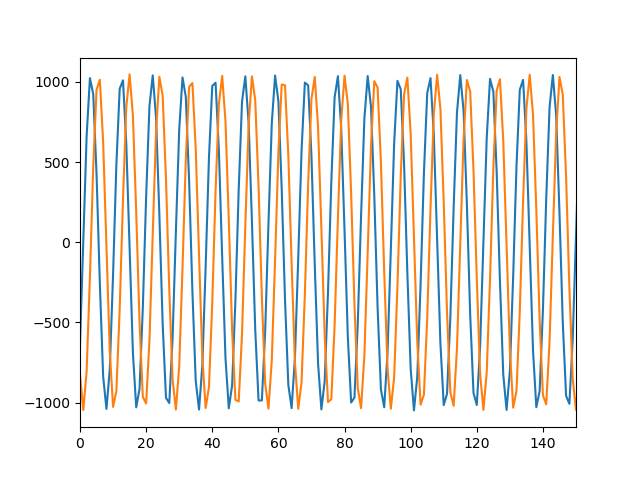

<IPython.core.display.Javascript object>


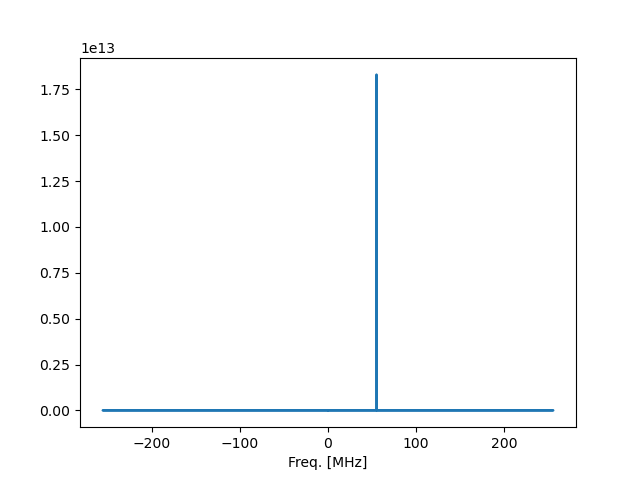

<IPython.core.display.Javascript object>


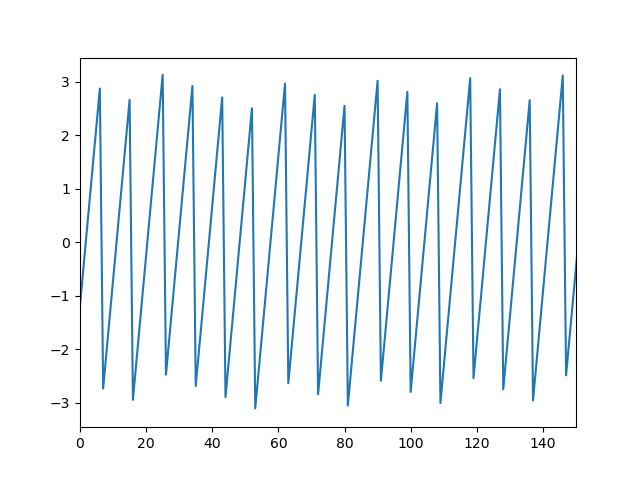

(0.0, 150.0)

In [67]:
%matplotlib notebook
I, Q = get_snap_data(1, 0)
c = slice(3750,4096)
plt.figure()
plt.plot(I[c])#/1024.)
plt.plot(Q[c])#/1024.)
plt.xlim(0,150)
spec = np.fft.fft(I + 1j*Q)
s_freq = np.fft.fftfreq(len(I),d=1./512e6)
plt.figure()
plt.plot(s_freq/1e6, np.abs(spec)**2)
plt.xlabel("Freq. [MHz]")
plt.show()

plt.figure()
plt.plot(np.arctan2(Q,I))
plt.xlim(0,150)

<IPython.core.display.Javascript object>


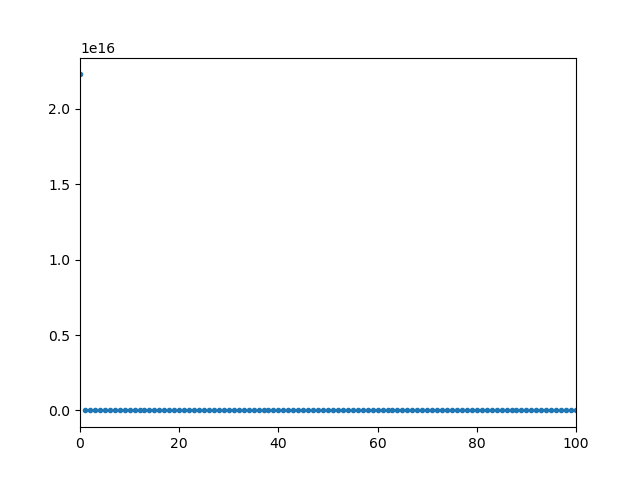

In [78]:
%matplotlib notebook
I, Q = get_snap_data(2, 3)
plt.figure()
plt.plot(I[4:]**2 + Q[4:]**2, '.')
plt.xlim(0,100)
#plt.ylim(0,10**(14))
plt.show()

In [30]:
# write phase freqs to ddc luts
# DDS shift debug loop
for step in range(512):
    firmware.chan1.dsp_regs_0.write(0x0c,step) # WRITING TO DDS SHIFT 
    sleep(.1)
    I, Q = get_snap_data(1, 3)
    IQddc=np.abs(I[0:1024].astype("float")+1j*Q[0:1024].astype("float"))
    peak=IQddc[np.argmax(IQddc[:1024])]
    print(step, peak)

0 54132900.74501113
1 20191.936063686415
2 16285.887295446939
3 16290.738595901661
4 18561.621480894388
5 20148.7791193412
6 16358.389285012141
7 16288.462235582585
8 16338.160055526449
9 16252.065622560105
10 16210.453170716728
11 16318.235719586844
12 20248.982690495835
13 20211.94144559102
14 20225.743002421445
15 16319.874754421371
16 16330.516127789715
17 20223.74359509139
18 16267.70162008143
19 16263.903252294635
20 20235.02470964639
21 20118.738255666034
22 16167.23414811575
23 16287.079050584853
24 20214.85300465972
25 16304.651176888146
26 20152.56613932826
27 16259.492027735676
28 20146.838958010263
29 20182.48183450192
30 20091.544614588496
31 16242.25021356339
32 16340.701973905527
33 20129.525801667558
34 16263.540358728784
35 16258.389834174846
36 20222.51121893619
37 16384.62587305551
38 19294.230121982062
39 20072.004807691734
40 16698.981436003814
41 20220.350392611894
42 16258.920782142952
43 20137.493116075795
44 16245.00886426351
45 20171.422557668062
46 16294.2132

368 20104.351071347715
369 20124.148926103684
370 16267.38147336565
371 20200.03415838696
372 19863.151008840465
373 16280.240938020543
374 20114.363847758148
375 20109.347975506316
376 16347.137517008903
377 20137.25664036688
378 16261.85859611379
379 16250.56614398403
380 16243.611328765533
381 16168.246318014826
382 16186.296735201662
383 20161.866605054205
384 20199.567445863784
385 16342.140894019976
386 20224.505556378874
387 20126.89228370838
388 20205.154441379556
389 20209.398061298114
390 20179.26026889985
391 20209.49056755266
392 20205.537186622878
393 20199.49078566091
394 20244.191191549246
395 16313.953352881697
396 20185.87357534967
397 18239.62817603473
398 20278.112831326293
399 16248.61378702811
400 16329.82660655036
401 20171.714106639523
402 16298.252667080604
403 20129.98432686921
404 20173.26411367283
405 20236.54281244699
406 20198.183383661017
407 20138.285974729824
408 20174.825525887456
409 20242.554087861543
410 20246.15580795525
411 20274.040791120056
412 1